# Preamble

In [1]:
import os, sys, json

import pandas as pd
import numpy as np
from scipy.stats import bootstrap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend import Legend
from matplotlib.ticker import FuncFormatter


import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss
from sklearn.utils import check_random_state

import lifelines as ll

from sksurv.ensemble import RandomSurvivalForest

# from eli5.permutation_importance import get_score_importances

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Global Config

In [2]:
# wow very nice, Jupyter
module_path = os.path.abspath(os.path.join("C:\\Users\\mmk\\PycharmProjects\\ckd"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# put %autoreload at the start of every cell using ckdlib attributes
%load_ext autoreload
# %autoreload 1
%aimport ckdlib.my_seaborn_plots
plib = ckdlib.my_seaborn_plots

%aimport ckdlib.modelling
mlib = ckdlib.modelling

%aimport ckdlib.formulae
flib = ckdlib.formulae

%aimport ckdlib.defs
defs = ckdlib.defs

%aimport ckdlib.utils
ulib = ckdlib.utils

## Global Data

In [4]:
# date of access
# this is used to drop rows that are less than 6 months before the date that the data was downloaded
# this is done because there is no way of knowing what will happen (or has happened) to that patient yet
DOA = pd.to_datetime("05/31/2021")

# study start and end times
SS = pd.to_datetime("01/03/2010")
SE = DOA

# first date in dataset
FY = pd.to_datetime("01/01/2005")

# time-to-endpoint threshold in months
ttes = [6, 12, 24]

DEFAULT_TTE_THRESH = 6 * 30
tte_thresh = DEFAULT_TTE_THRESH

data_file = "../data/data_unified.xlsx"

## Functions

### General

In [5]:
def bootstrappah(g, var_to_strap):
    rng = np.random.default_rng()
    data = (g[var_to_strap].to_numpy(),)
    
    conf_low, conf_high = bootstrap(
        data, np.mean, confidence_level=0.95, n_resamples=10000, random_state=rng
    ).confidence_interval
    
    return str(round(np.mean(g[var_to_strap].to_numpy()), 2)) \
            + " [" + str(round(conf_low, 2)) \
            + ", " + str(round(conf_high, 2)) + "]"


def format_for_sksurv(D):
    cens = D.censor.to_numpy()
    sas = D.sa_time.to_numpy()

    ret = list()

    for i, c in enumerate(cens):
        ret.append((c == 0, sas[i]))

    return np.asarray(ret, dtype=[("status", "?"), ("time", "int")])

### KFold CV

In [ ]:
def kfold_cv_together(x, y, weights, n_splits, var_sets, timeframe=6, t_unit="M"):
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    sgkf_tt = StratifiedGroupKFold(n_splits=n_splits)
    folds = [f for f in sgkf_tt.split(x, y, groups=x.pt_id)]
    
    t_indexer = timeframe if t_unit == "M" else timeframe * 30

    # output dfs for rfc
    feats = np.asarray(["brier", "auc_roc", "auc_prc", "th", "prre50", "prre60", "prre70", "prre80", "v", "t"])
    perfs_folds = pd.DataFrame(np.empty(shape=(n_splits * len(var_sets), len(feats))), columns=feats)

    # output dfs for rsf
    rsf_folds = pd.DataFrame(np.empty(shape=(n_splits * len(var_sets), len(feats))), columns=feats)
    
    # output dfs for Cox
    output_b = pd.DataFrame(np.empty(shape=(n_splits * len(var_sets), len(feats))), columns=feats)
    output_tv = pd.DataFrame(np.empty(shape=(n_splits * len(var_sets), len(feats))), columns=feats)
    
    # hazard ratios and importances
    hr_bs, hr_tvs, feat_imps_rfcs, feat_imps_rsfs = list(), list(), list(), list()
    p_bs, p_tvs = list(), list()
    
    for vi, var_set in enumerate(var_sets):

        hr_b = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)
        hr_tv = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)

        p_b = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)
        p_tv = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)

        feat_imps_rfc = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)
        feat_imps_rsf = pd.DataFrame(np.empty(shape=(n_splits, len(var_set))), columns=var_set)

        for fold, (train_i, test_i) in enumerate(folds):
            x_train = x.loc[train_i]
            y_train = y.loc[train_i]
            x_test = x.loc[test_i]
            y_test = y.loc[test_i]

            ####### RFC START #######
            # RF
            model = RandomForestClassifier(
                max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, class_weight=weights, n_jobs=-1
            )
            probs = model.fit(x_train[var_set], y_train).predict_proba(x_test[var_set]).round(6)

            fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
            ps, rs, pr_thresholds = precision_recall_curve(y_test, probs[:, 1])

            br, aucroc, aucpr = brier_score_loss(y_test, probs[:, 1]), auc(fpr, tpr), auc(rs, ps)
            
            # max prec at 70% sens
            sample_max_ppv80 = (ps)[rs >= 0.8].max()
            th = (pr_thresholds)[np.diff(rs >= 0.8)][0]

            sample_max_ppv70 = (ps)[rs >= 0.7].max()
            th = (pr_thresholds)[np.diff(rs >= 0.7)][0]

            sample_max_ppv60 = (ps)[rs >= 0.6].max()
            th = (pr_thresholds)[np.diff(rs >= 0.6)][0]

            sample_max_ppv50 = (ps)[rs >= 0.5].max()
            th = (pr_thresholds)[np.diff(rs >= 0.5)][0]

            
            print(
                "ML VarSet {} : Timeframe {} ({}) : Fold {} >>> AUC-ROC {:.3f} | AUC-PR {:.3f} | Max. Prec.@70%Sens. {:.3f}".format(
                    vi, timeframe, timeframe * 30, fold, aucroc, aucpr, sample_max_ppv70
                )
            )
            perfs_folds.iloc[(vi * n_splits) + fold] = [br, aucroc, aucpr, th, sample_max_ppv50, sample_max_ppv60, sample_max_ppv70, sample_max_ppv80, vi, timeframe]

            ####### COX START #######
            # ~~~~~ SETUP ~~~~~ #
            # individuals baseline
            inds_b = x_train.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)

            data_b = inds_b[var_set].copy()
            means_b = data_b[var_set].mean()
            data_b[var_set] -= means_b

            data_b = pd.concat([data_b, inds_b[["censor", "sa_time"]]], axis=1)
            data_b["censor"] = (data_b.censor == 0).astype(int)

            # time-varying
            data_tv = x_train[var_set].copy()
            means_tv = data_tv[var_set].mean()
            data_tv[var_set] -= means_tv

            data_tv = pd.concat([data_tv, x_train[["pt_id", "start", "stop", "event"]]], axis=1)

            # don't center categoricals like gender
            for v in var_set:
                if v in defs.cat_voi:
                    data_b[v] = inds_b[v].copy()
                    data_tv[v] = x_train[v].copy()


            # ~~~~~ FITTING ~~~~~ #
            cph_b = ll.CoxPHFitter()
            cph_b.fit(data_b, duration_col="sa_time", event_col="censor")

            cph_tv = ll.CoxTimeVaryingFitter()
            cph_tv.fit(data_tv, id_col="pt_id", event_col="event", start_col="start", stop_col="stop")

            # ~~~~~ PREDICTING ~~~~~ #
            # BASELINE
            # need to center predictors
            test_b = x_test[var_set] - means_b
            true_b = y_test.loc[test_b.index]

            # building equation
            beta_b = cph_b.params_.ravel()        
            S0t_b = cph_b.baseline_survival_

            ris_b = np.exp(np.apply_along_axis(np.dot, 1, test_b[cph_b.params_.index], beta_b))
            Sts_b = np.apply_along_axis(np.power, 1, S0t_b, ris_b)

            probs_b = np.empty(shape=test_b.shape[0])

            for i in range(len(test_b)):
                St_b = Sts_b[:,i]

                if t_indexer in set(S0t_b.index):                        
                    prob = pd.DataFrame(St_b, index=S0t_b.index).loc[t_indexer].to_numpy()[0]
                    probs_b[i] = 1 - prob
                else:
                    probs_b[i] = 1 - St_b[abs((S0t_b.index - t_indexer).to_numpy()).argsort()[:2]].mean()

            fpr, tpr, thresholds = roc_curve(true_b, probs_b)
            ps, rs, pr_thresholds = precision_recall_curve(true_b, probs_b)

            br, aucroc, aucpr = brier_score_loss(true_b, probs_b), auc(fpr, tpr), auc(rs, ps)

            # max prec at 70% sens
            sample_max_ppv80 = (ps)[rs >= 0.8].max()
            th = (pr_thresholds)[np.diff(rs >= 0.8)][0]

            sample_max_ppv70 = (ps)[rs >= 0.7].max()
            th = (pr_thresholds)[np.diff(rs >= 0.7)][0]

            sample_max_ppv60 = (ps)[rs >= 0.6].max()
            th = (pr_thresholds)[np.diff(rs >= 0.6)][0]

            sample_max_ppv50 = (ps)[rs >= 0.5].max()
            th = (pr_thresholds)[np.diff(rs >= 0.5)][0]

            print(
                "BL VarSet {} : Timeframe {} ({}) : Fold {} >>> AUC-ROC {:.3f} | AUC-PR {:.3f} | Max. Prec.@70%Sens. {:.3f}".format(
                    vi, timeframe, timeframe * 30, fold, aucroc, aucpr, sample_max_ppv70
                )
            )
            output_b.iloc[(vi * n_splits) + fold] = [br, aucroc, aucpr, th, sample_max_ppv50, sample_max_ppv60, sample_max_ppv70, sample_max_ppv80, vi, timeframe]

            ###
            # TIME VARYING
            # need to center predictors
            # these are the same patients and visits, but the predictors are centered differently according to the means of the train set
            test_tv = x_test[var_set] - means_tv
            true_tv = y_test.loc[test_tv.index]

            # parameters and stuff
            beta_tv = cph_tv.params_.ravel()        
            S0t_tv = cph_tv.baseline_survival_
            H0t_tv = cph_tv.baseline_cumulative_hazard_

            ris_tv = np.exp(np.apply_along_axis(np.dot, 1, test_tv[cph_tv.params_.index], beta_tv))
            Sts_tv = np.apply_along_axis(np.power, 1, S0t_tv, ris_tv)
            probs_tv = np.empty(shape=test_tv.shape[0])
                       
            for i in range(len(test_tv)):
                St_tv = Sts_tv[:,i]

                if t_indexer in set(S0t_tv.index):
                    prob = pd.DataFrame(St_tv, index=S0t_tv.index).loc[t_indexer].to_numpy()[0]
                    probs_tv[i] = 1 - prob
                else:
                    probs_tv[i] = 1 - St_tv[abs((S0t_tv.index - t_indexer).to_numpy()).argsort()[:2]].mean()

            fpr, tpr, thresholds = roc_curve(true_tv, probs_tv)
            ps, rs, pr_thresholds = precision_recall_curve(true_tv, probs_tv)
            
            br, aucroc, aucpr = brier_score_loss(true_tv, probs_tv), auc(fpr, tpr), auc(rs, ps)

            # max prec at 70% sens
            sample_max_ppv80 = (ps)[rs >= 0.8].max()
            th = (pr_thresholds)[np.diff(rs >= 0.8)][0]

            sample_max_ppv70 = (ps)[rs >= 0.7].max()
            th = (pr_thresholds)[np.diff(rs >= 0.7)][0]

            sample_max_ppv60 = (ps)[rs >= 0.6].max()
            th = (pr_thresholds)[np.diff(rs >= 0.6)][0]

            sample_max_ppv50 = (ps)[rs >= 0.5].max()
            th = (pr_thresholds)[np.diff(rs >= 0.5)][0]

            print(
                "TVP VarSet {} : Timeframe {} ({}) : Fold {} >>> AUC-ROC {:.3f} | AUC-PR {:.3f} | Max. Prec.@70%Sens. {:.3f}".format(
                    vi, timeframe, timeframe * 30, fold, aucroc, aucpr, sample_max_ppv70
                )
            )
            output_tv.iloc[(vi * n_splits) + fold] = [br, aucroc, aucpr, th, sample_max_ppv50, sample_max_ppv60, sample_max_ppv70, sample_max_ppv80, vi, timeframe]
            
            ####### RSF START #######
            # RSF
            rsf = RandomSurvivalForest(
                max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, n_jobs=-1
            )
            # make format for sksurv (list of tuples: (censor, sa_time))
            inds_rsf = x_train.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)
            x_rsf = inds_rsf[var_set].copy()
            y_rsf = format_for_sksurv(inds_rsf[["censor", "sa_time"]])

            rsf.fit(x_rsf, y_rsf)
            test_rsf = x_test[var_set].copy()
            true_rsf = y_test.loc[test_rsf.index].copy()

            rsf_index = rsf.event_times_
            probs_rsf = np.empty(shape=test_rsf.shape[0])

            rsf_survs = rsf.predict_survival_function(test_rsf, return_array=True)

            for i in range(len(test_rsf)):
                St_rsf = rsf_survs[i]

                if t_indexer in set(rsf_index):
                    prob = pd.DataFrame(St_rsf, index=rsf_index).loc[t_indexer].to_numpy()[0]
                    probs_rsf[i] = 1 - prob
                else:
                    probs_rsf[i] = 1 - St_rsf[abs(rsf_index - t_indexer).argsort()[:2]].mean()

            probs_rsf = probs_rsf.round(6)              

            fpr, tpr, thresholds = roc_curve(true_rsf, probs_rsf)
            ps, rs, pr_thresholds = precision_recall_curve(true_rsf, probs_rsf)

            br, aucroc, aucpr = brier_score_loss(true_rsf, probs_rsf), auc(fpr, tpr), auc(rs, ps)

            # max prec at 70% sens
            sample_max_ppv80 = (ps)[rs >= 0.8].max()
            th = (pr_thresholds)[np.diff(rs >= 0.8)][0]

            sample_max_ppv70 = (ps)[rs >= 0.7].max()
            th = (pr_thresholds)[np.diff(rs >= 0.7)][0]

            sample_max_ppv60 = (ps)[rs >= 0.6].max()
            th = (pr_thresholds)[np.diff(rs >= 0.6)][0]

            sample_max_ppv50 = (ps)[rs >= 0.5].max()
            th = (pr_thresholds)[np.diff(rs >= 0.5)][0]

            print(
                "RSF VarSet {} : Timeframe {} ({}) : Fold {} >>> AUC-ROC {:.3f} | AUC-PR {:.3f} | Max. Prec.@70%Sens. {:.3f}".format(
                    vi, timeframe, timeframe * 30, fold, aucroc, aucpr, sample_max_ppv70
                )
            )
            rsf_folds.iloc[(vi * n_splits) + fold] = [br, aucroc, aucpr, th, sample_max_ppv50, sample_max_ppv60, sample_max_ppv70, sample_max_ppv80, vi, timeframe]

            ####### FEATURE IMPORTANCE (NOT REPORTED, JUST PRINTED) #######
            hr_b.iloc[fold] = cph_b.params_[var_set].ravel()
            hr_tv.iloc[fold] = cph_tv.params_[var_set].ravel()
            p_b.iloc[fold] = cph_b.summary.p[var_set].ravel()
            p_tv.iloc[fold] = cph_tv.summary.p[var_set].ravel()

            print(
                pd.DataFrame(data=pd.concat(
                    [cph_b.params_[var_set], cph_b.summary.p[var_set]], axis=1
                ), columns=["coef", "p"], index=var_set).T.rename(dict(coef="BL HRs"))
            )
            print(
                pd.DataFrame(data=pd.concat(
                    [cph_tv.params_[var_set].rename("TVP HRs"), cph_tv.summary.p[var_set]], axis=1
                ), columns=["TVP HRs", "p"], index=var_set).T
            )

            def scorer_rfc(X, y):
                y_pred = model.predict_proba(X)
                return brier_score_loss(y, y_pred[:, 1])

            def scorer_rsf(X, y):
                y_pred = np.empty(shape=X.shape[0])
                survs = rsf.predict_survival_function(X, return_array=True)

                for i in range(len(X)):
                    St_rsf = survs[i]

                    if t_indexer in set(rsf_index):
                        prob = pd.DataFrame(St_rsf, index=rsf_index).loc[t_indexer].to_numpy()[0]
                        y_pred[i] = 1 - prob
                    else:
                        y_pred[i] = 1 - St_rsf[abs(rsf_index - t_indexer).argsort()[:2]].mean()

                return brier_score_loss(y, y_pred)

            cols_in = x_test[var_set].columns.to_numpy()
            base_rfc_score, rfc_score_dec = get_score_importances(scorer_rfc, x_test[var_set].to_numpy(), y_test)
            rfc_res = pd.DataFrame(data=np.mean(rfc_score_dec, axis=0).reshape(1, -1), columns=cols_in, index=["rfc_imps"])
            print(rfc_res)

            cols_in = test_rsf.columns.to_numpy()
            base_rsf_score, rsf_score_dec = get_score_importances(scorer_rsf, test_rsf.to_numpy(), true_rsf)
            rsf_res = pd.DataFrame(data=np.mean(rsf_score_dec, axis=0).reshape(1, -1), columns=cols_in, index=["rsf_imps"])
            print(rsf_res)

            feat_imps_rfc.iloc[fold] = rfc_res[var_set]
            feat_imps_rsf.iloc[fold] = rsf_res[var_set]

        hr_bs.append(hr_b)
        hr_tvs.append(hr_tv)
        p_bs.append(p_b)
        p_tvs.append(p_tv)
        feat_imps_rfcs.append(feat_imps_rfc)
        feat_imps_rsfs.append(feat_imps_rsf)

            
    # giving the thresholds used for auc computations, performance over each fold 
    # (which is now the same across methods), and last fold predictions (both methods) for some plots
    return (
        (thresholds, perfs_folds, probs), 
        (output_b, output_tv, Sts_b, Sts_tv), 
        (rsf_folds, rsf_survs),
        (hr_bs, hr_tvs, feat_imps_rfcs, feat_imps_rsfs),
        (p_bs, p_tvs)
    )

### Figures

In [6]:
def reset_mpl():
    mpl.rcParams.update(mpl.rcParamsDefault)
    
def set_mpl():
    
    font = {
    "family": "Arial",
    "size": 22
    }
    
    plt.rc("font", **font)
    plt.rc("xtick", labelsize=20)
    plt.rc("ytick", labelsize=20)
    plt.rc("axes", labelweight="bold")
    plt.rc("axes", titleweight="bold")

def make_panel(d, prre):
    plt.style.use("default")
    g = sns.catplot(
        x="Timeframe (Months)", y="Metric Value", hue="Name", col="Metric",
        data=d.loc[(d.Metric == "AUC-ROC") | (d.Metric == "AUC-PR") | (d.Metric == prre)], kind="point", 
        ci=95, n_boot=10000, dodge=0.4, aspect=1, palette=["#47568F", "#5B869E", "#6EB6AD", "#070706", "#975061", "#8377D1"], join=False, capsize=0.00,
        col_wrap=3,
        sharey=True,
        sharex=False,
        col_order=["AUC-ROC", "AUC-PR", prre],
        hue_order=["Cox Baseline", "Cox Time-Varying",  "Random Survival Forest", "Random Forest Classifier"],
        markers=["_", "_", "_", "_"], scale=1.5,
        errwidth=1.5,
        legend=False,
        facet_kws={},
        **{"sym":""}
    )

    # 0 -------------------
    g.axes[0].hlines(
        y=[0.5, 0.6, 0.7, 0.8, 0.9], xmin=-0.25, xmax=2.25, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    g.axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), title="AUC-ROC", title_fontproperties=dict(weight="bold"), 
                     ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.1, edgecolor="black")

    leg2 = Legend(g.axes[0], [], [], loc="upper center", bbox_to_anchor=(0, 1.1), title="A", title_fontproperties=dict(weight="bold", size="18"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    g.axes[0].add_artist(leg2)

    g.despine(right=False, top=False)
    g.axes[0].set_title("")#, pad=15.0, fontdict=dict(fontweight="bold"))
    g.axes[0].set_ylabel("Cross-Validation Mean [95% CI]", fontdict=dict(fontweight="bold"))
    g.axes[0].set_xlabel("Timeframe (Months)", fontdict=dict(fontweight="bold"))
    g.axes[0].set_ylim((0.5, 1))

    # 1 -------------------
    g.axes[1].hlines(
        y=[0.5, 0.6, 0.7, 0.8, 0.9], xmin=-0.25, xmax=2.25, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    g.axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), title="AUC-PR", title_fontproperties=dict(weight="bold"), 
                     ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.1, edgecolor="black")

    leg2 = Legend(g.axes[1], [], [], loc="upper center", bbox_to_anchor=(0, 1.1), title="B", title_fontproperties=dict(weight="bold", size="18"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    g.axes[1].add_artist(leg2)

    g.despine(right=False, top=False)
    g.axes[1].set_title("")#, pad=15.0, fontdict=dict(fontweight="bold"))
    g.axes[1].set_xlabel("Timeframe (Months)", fontdict=dict(fontweight="bold"))
    g.axes[1].set_ylim((0.5, 1))

    # 2 -------------------
    g.axes[2].hlines(
        y=[0.5, 0.6, 0.7, 0.8, 0.9], xmin=-0.25, xmax=2.25, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )
    g.axes[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), title=prre, title_fontproperties=dict(weight="bold"), 
                     ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.1, edgecolor="black")

    leg2 = Legend(g.axes[2], [], [], loc="upper center", bbox_to_anchor=(0, 1.1), title="C", title_fontproperties=dict(weight="bold", size="18"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    g.axes[2].add_artist(leg2)

    g.despine(right=False, top=False)
    g.axes[2].set_title("")#, pad=15.0, fontdict=dict(fontweight="bold"))
    g.axes[2].set_xlabel("Timeframe (Months)", fontdict=dict(fontweight="bold"))
    g.axes[2].set_ylim((0.5, 1))

    plt.tight_layout()
    plt.show()

# Preprocessing

In [ ]:
df_master = pd.read_excel(data_file, sheet_name=None)["UNIFIED"]

In [ ]:
df = df_master.copy()

# number of unique patients (before drop)
df.pt_id.unique().shape

(2432,)

In [ ]:
%autoreload

# variables of interest
kfre_o = defs.var_sets[-1] + ["measd_sbp", "measd_dbp", "bmi", "alb", "creat", "pmh_chf", "potassium"]
kfre_o

['pmh_hyper',
 'gender',
 'alb',
 'acr',
 'age',
 'egfr_epi_nr',
 'diabetes',
 'phos',
 'total_co2',
 'calc',
 'measd_sbp',
 'measd_dbp',
 'bmi',
 'alb',
 'creat',
 'pmh_chf',
 'potassium']

In [ ]:
# exclusion criteria
df = df.loc[(df.ex_crit == 0)]

# missing predictors
df = df.dropna(subset=kfre_o)

In [ ]:
# building 3 datasets labeled for 6, 12, and 24 months respectively
dfs_dict = dict()

for tte in ttes:
    dft = df.copy()
    
    # putting in label; defined as time-to-endpoint <= tte_thresh (6 months)
    dft["label"] = 0

    # inpatient KRT
    dft.loc[
        ((dft["patransf_where"] == 5) | (dft["patransf_where"] == 6)) & (dft["sa_time_visit"] <= tte * 30), 
        "label"
    ] = 1

    # planned KRT
    dft.loc[
        ((dft["patransf_where"] == 2) | (dft["patransf_where"] == 3) 
         | (dft["patransf_where"] == 4) | (dft["patransf_where"] == 7)) & (dft["sa_time_visit"] <= tte * 30), "label"
    ] = 1
    
    # exclude patients censored by DOA; we cannot say if they need KRT 6/12/24 months away
    # drop entries that are less than 24 months before the date of access and have no tte
    dft = dft.loc[
        ~((dft.patransf_pri == 0) & (dft.cs_pt_alive == 1) & (((DOA - dft.fup_date) / np.timedelta64(1, "D")) < 24 * 30))
    ].reset_index(drop=True)
    
    # printing 
    print(dft["label"].value_counts())
    print(len(dft["pt_id"].unique()))
    
    # splitting for train and holdout test (80, 20); we will take the first fold indices as first data split
    sgkf_tt = StratifiedGroupKFold(n_splits=5)

    train_test_folds = [f for f in sgkf_tt.split(dft.drop(columns=["label"]), dft.label, dft.pt_id)]
    
    dfs_dict["df" + str(tte)] = (dft, dft.loc[train_test_folds[0][0]], dft.loc[train_test_folds[0][1]])

0    9837
1    2800
Name: label, dtype: int64
1918
0    8024
1    4613
Name: label, dtype: int64
1918
1    6797
0    5840
Name: label, dtype: int64
1918


# Table 1

In [ ]:
# baseline visit
charsbl_o = dict()
bldf = df.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)

for v in kfre_o:
    
    if v in (defs.base_lab_vars | defs.base_meas_vars):
    
        vo = v   
        charsbl_o[vo] = bldf[vo].describe()
        
out_bl = pd.DataFrame(charsbl_o).T.round(2)
out_bl

,count,mean,std,min,25%,50%,75%,max
alb,1918.0,34.58,4.94,15.00,32.00,35.00,38.00,50.00
acr,1918.0,204.83,229.86,0.00,51.89,131.54,272.66,2462.69
egfr_epi_nr,1918.0,17.05,5.88,4.63,13.00,16.24,20.31,50.34
phos,1918.0,1.37,0.31,0.63,1.17,1.34,1.52,3.30
total_co2,1918.0,23.97,3.38,13.00,22.00,24.00,26.00,42.00
calc,1918.0,2.22,0.15,1.43,2.14,2.22,2.31,3.07
measd_sbp,1918.0,136.85,20.89,75.00,122.00,136.00,150.00,220.00
measd_dbp,1918.0,71.75,12.97,28.00,62.00,70.00,80.00,140.00
bmi,1918.0,29.94,7.02,9.60,25.10,28.95,33.68,67.00
creat,1918.0,312.83,99.65,118.00,244.00,294.00,362.00,891.00


In [ ]:
# all visits
chars_o = dict()

for v in kfre_o:
    
    if v in (defs.base_lab_vars | defs.base_meas_vars):
    
        vo = v    
        chars_o[v] = df[vo].describe()
        
out = pd.DataFrame(chars_o).T.round(2)
out

,count,mean,std,min,25%,50%,75%,max
alb,12637.0,36.39,5.05,10.00,33.00,37.00,40.00,51.00
acr,12637.0,170.92,201.80,0.00,45.13,110.51,219.83,4699.23
egfr_epi_nr,12637.0,14.87,5.64,3.26,10.69,14.11,18.06,50.34
phos,12637.0,1.44,0.33,0.19,1.21,1.39,1.62,6.27
total_co2,12637.0,23.48,3.37,9.00,21.00,23.00,26.00,42.00
calc,12637.0,2.24,0.16,1.05,2.15,2.24,2.34,3.54
measd_sbp,12637.0,136.57,19.29,20.00,124.00,135.00,148.00,230.00
measd_dbp,12637.0,71.51,12.27,11.00,62.00,70.00,80.00,165.00
bmi,12637.0,30.13,7.08,4.20,25.10,29.00,34.00,68.50
creat,12637.0,357.07,126.59,97.00,267.00,331.00,421.00,1348.00


In [ ]:
# missing baseline
1 - (out_bl["count"] / 1918.0)

alb            0.0
acr            0.0
egfr_epi_nr    0.0
phos           0.0
total_co2      0.0
calc           0.0
measd_sbp      0.0
measd_dbp      0.0
bmi            0.0
creat          0.0
potassium      0.0
Name: count, dtype: float64

In [ ]:
print(bldf.pmh_hyper.value_counts(normalize=True))
print(bldf.pmh_hyper.value_counts())

1    0.91658
0    0.08342
Name: pmh_hyper, dtype: float64
1    1758
0     160
Name: pmh_hyper, dtype: int64


In [ ]:
print(bldf.pmh_chf.value_counts(normalize=True))
print(bldf.pmh_chf.value_counts())

0    0.772158
1    0.227842
Name: pmh_chf, dtype: float64
0    1481
1     437
Name: pmh_chf, dtype: int64


In [ ]:
print(bldf.diabetes.value_counts(normalize=True))
print(bldf.diabetes.value_counts())

1    0.598019
0    0.401981
Name: diabetes, dtype: float64
1    1147
0     771
Name: diabetes, dtype: int64


In [ ]:
print(bldf.gender.value_counts(normalize=True))
print(bldf.gender.value_counts())

0    0.62878
1    0.37122
Name: gender, dtype: float64
0    1206
1     712
Name: gender, dtype: int64


In [ ]:
bldf.age.describe()

count    1918.000000
mean       66.235151
std        14.778135
min        18.110000
25%        57.550000
50%        68.160000
75%        77.030000
max        98.200000
Name: age, dtype: float64

In [ ]:
# ace inhibitor
drugs.loc[drugs.pt_id.isin(bldf.pt_id)].drop_duplicates(subset="pt_id").RAS_I_Final.value_counts()

0    963
1    836
Name: RAS_I_Final, dtype: int64

In [ ]:
# diuretic
gne = drugs.loc[drugs.pt_id.isin(bldf.pt_id)].drop_duplicates(subset="pt_id")
gne.loc[(gne.Thiazide_final == 1) | (gne.Aldo_final == 1) | (gne.loop_final == 1)].shape

(1105, 6)

In [ ]:
# percentages with respect to actual df size (im assuming 0s for the missing patients)
print(836/1918)
print(1105/1918)

0.4358706986444213
0.5761209593326382


In [ ]:
# KRT start type
# hds
print(np.sum([bldf.patransf_where.value_counts().loc[3], bldf.patransf_where.value_counts().loc[5], bldf.patransf_where.value_counts().loc[7]]) / 1918)
print(np.sum([bldf.patransf_where.value_counts().loc[3], bldf.patransf_where.value_counts().loc[5], bldf.patransf_where.value_counts().loc[7]]))

# pds
print(np.sum([bldf.patransf_where.value_counts().loc[4], bldf.patransf_where.value_counts().loc[6]]) / 1918)
print(np.sum([bldf.patransf_where.value_counts().loc[4], bldf.patransf_where.value_counts().loc[6]]))

# preempts
print(np.sum([bldf.patransf_where.value_counts().loc[2]]) / 1918)
print(np.sum([bldf.patransf_where.value_counts().loc[2]]))

0.3858185610010427
740
0.251303441084463
482
0.05057351407716371
97


In [ ]:
# deaths
bldf.cs_pt_alive.value_counts()

1    1521
0     397
Name: cs_pt_alive, dtype: int64

In [ ]:
df.sa_time_visit.describe()

count    12637.000000
mean       643.863496
std        627.265487
min          1.000000
25%        176.000000
50%        449.000000
75%        925.000000
max       3935.000000
Name: sa_time_visit, dtype: float64

In [ ]:
bldf.sa_time_visit.describe()

count    1918.000000
mean      770.485923
std       670.949574
min         3.000000
25%       271.000000
50%       589.500000
75%      1065.000000
max      3935.000000
Name: sa_time_visit, dtype: float64

# KFRE (24 Months)

In [ ]:
%autoreload

df24 = dfs_dict["df24"][0].copy()

ages = df24.age.to_numpy()
genders = df24.gender.to_numpy()
gfrs = df24.egfr_epi_nr.to_numpy()
acrs = df24.acr.to_numpy() / 0.113

kfre_probs2 = flib.kfre_4v_nonNA(ages, genders, gfrs, acrs)

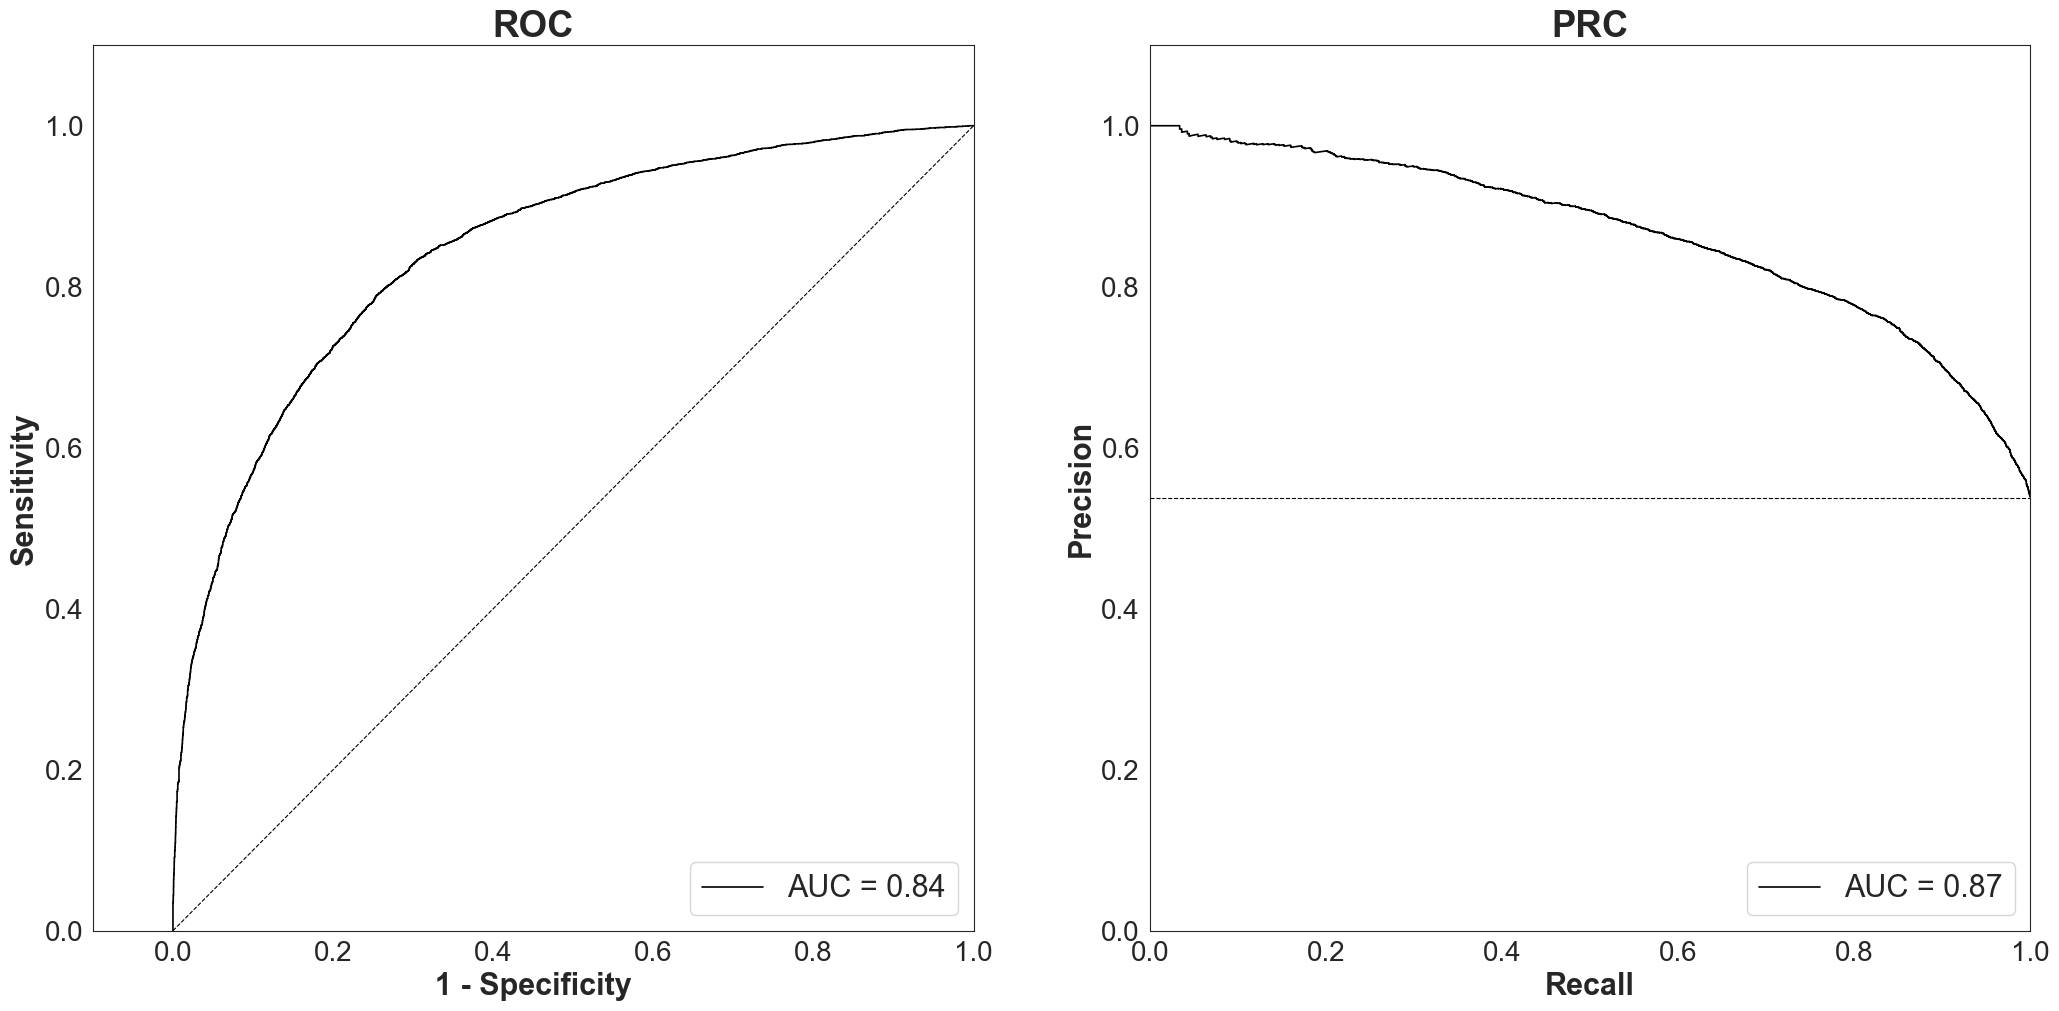

In [ ]:
%autoreload

set_mpl()

plib.my_roc_prc_probs(df24.label.to_numpy(), kfre_probs2[:,0])

reset_mpl()

# VA (12 Months)

In [ ]:
%autoreload

df12 = dfs_dict["df12"][0].copy()#.drop_duplicates(subset="pt_id")

gfrs = df12.egfr_epi_nr.to_numpy()
chfs = df12.pmh_chf.to_numpy()
ages = df12.age.to_numpy()
albs = df12.alb.to_numpy() * 0.1
pots = df12.potassium.to_numpy()
sbps = df12.measd_sbp.to_numpy()

va_probs = flib.va(gfrs, chfs, ages, albs, pots, sbps)

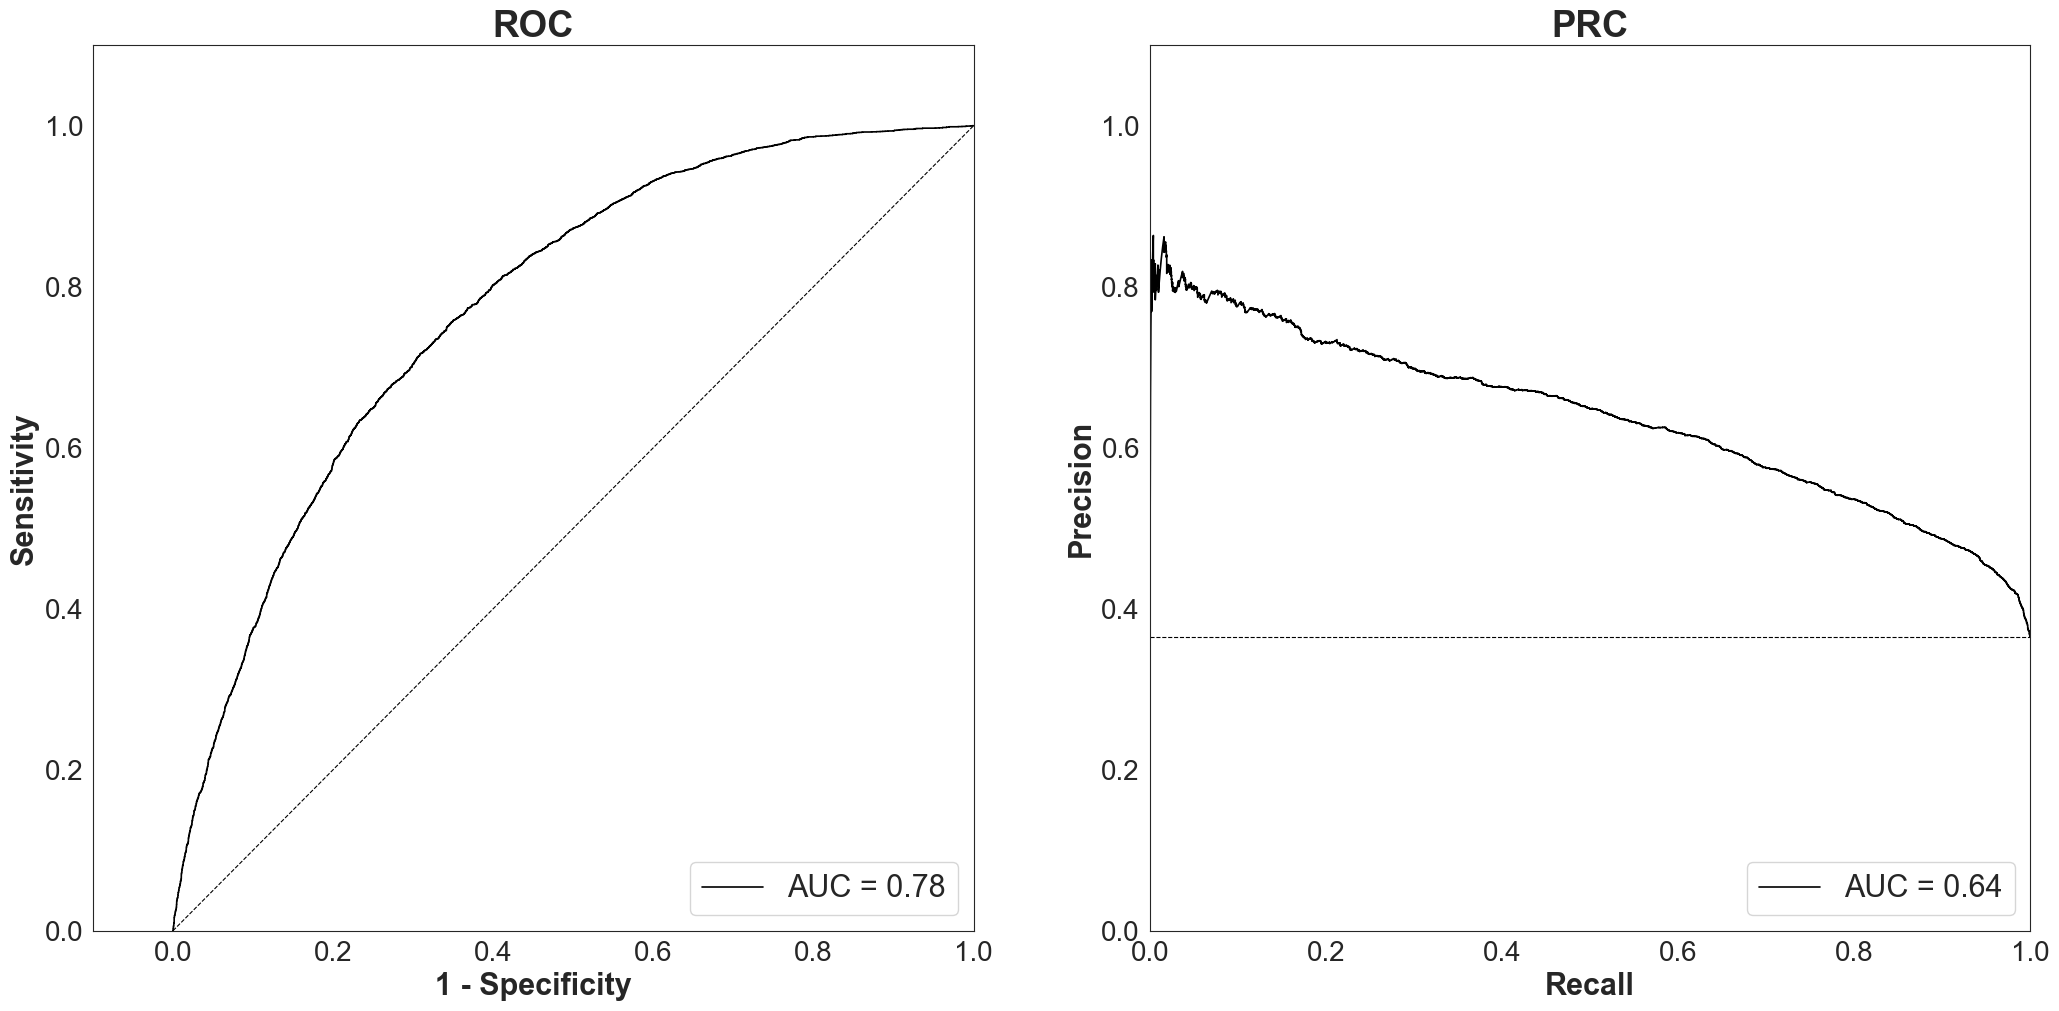

In [ ]:
%autoreload

set_mpl()

plib.my_roc_prc_probs(df12.label.to_numpy(), va_probs[:,0])

reset_mpl()

# Table 2

In [ ]:
kfolds = 5

results = []
vs = [
    ["acr", "age", "egfr_epi_nr", "gender"],
    ["acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2", "potassium", "pmh_chf", "measd_sbp"]
]

for dk in dfs_dict.keys():
    dfk = dfs_dict[dk][0]
    
    classes_weights = {0: len(dfk.label) / (2 * dfk.label.value_counts()[0]), 
                       1: len(dfk.label) / (2 * dfk.label.value_counts()[1])}
    
    results.append(kfold_cv_together(dfk.drop(columns=["label"]), dfk.label, classes_weights, kfolds, vs, timeframe=int(dk.replace("df", "")), t_unit="D"))

ML VarSet 0 : Timeframe 6 (180) : Fold 0 >>> AUC-ROC 0.867 | AUC-PR 0.681 | Max. Prec.@70%Sens. 0.601
BL VarSet 0 : Timeframe 6 (180) : Fold 0 >>> AUC-ROC 0.841 | AUC-PR 0.613 | Max. Prec.@70%Sens. 0.520
TVP VarSet 0 : Timeframe 6 (180) : Fold 0 >>> AUC-ROC 0.868 | AUC-PR 0.670 | Max. Prec.@70%Sens. 0.587
RSF VarSet 0 : Timeframe 6 (180) : Fold 0 >>> AUC-ROC 0.874 | AUC-PR 0.705 | Max. Prec.@70%Sens. 0.613
                 acr           age   egfr_epi_nr    gender
BL HRs  1.312029e-03 -2.784454e-02 -1.196826e-01 -0.202050
p       3.614060e-63  1.715567e-38  2.744249e-69  0.001716
                  acr           age  egfr_epi_nr    gender
TVP HRs  1.074962e-03 -2.064674e-02    -0.408648 -0.308391
p        2.991401e-29  3.112165e-23     0.000000  0.000002
              acr       age  egfr_epi_nr    gender
rfc_imps -0.01488 -0.006874    -0.123106 -0.000088
               acr       age  egfr_epi_nr    gender
rsf_imps -0.021721 -0.002022    -0.081147 -0.000202
ML VarSet 0 : Timeframe 6 (180

In [ ]:
# DATAFRAME CONSTRUCTION EXCLUDED

In [ ]:
# write out to avoid retraining each time
data.to_csv("../out/results/test_perfs_{}.csv".format(ulib.get_time_now_str("dmy")))

In [7]:
# optional read in
data = pd.read_csv("../out/results/test_perfs_23-7-2022.csv").drop(columns=["Unnamed: 0"])
data

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type
0,bl6,0,6,cox,brier,0.140384,6,Brier,Cox-BL
1,bl6,0,6,cox,brier,0.135866,6,Brier,Cox-BL
2,bl6,0,6,cox,brier,0.129702,6,Brier,Cox-BL
3,bl6,0,6,cox,brier,0.140744,6,Brier,Cox-BL
4,bl6,0,6,cox,brier,0.137052,6,Brier,Cox-BL
...,...,...,...,...,...,...,...,...,...
1925,va,0,12,ext,brier,NaN,12,Brier,Ext.
1926,va,0,12,ext,auc_roc,0.775539,12,AUC-ROC,Ext.
1927,va,0,12,ext,auc_prc,0.636879,12,AUC-PR,Ext.
1928,va,0,12,ext,th,0.000000,12,NaN,Ext.


In [8]:
order = ["bl6", "rsf6", "tv6", "ml6", "bl12", "rsf12", "tv12", "ml12", "bl24", "rsf24", "tv24", "ml24"]
names = ["Cox Baseline", "Cox Time-Varying",  "Random Survival Forest", "Random Forest Classifier"]

prre = "PrRe70"
metrics = {"AUC-ROC", "AUC-PR", prre, "Brier"}

data["Name"] = ""
data.loc[data.Type == "Cox-BL", "Name"] = "Cox Baseline"
data.loc[data.Type == "Cox-TVC", "Name"] = "Cox Time-Varying"
data.loc[data.Type == "RSF", "Name"] = "Random Survival Forest"
data.loc[data.Type == "RFC", "Name"] = "Random Forest Classifier"

## 4 Variable Set

In [ ]:
data4 = data.loc[(data.v == 0) & (data.group != "ext") & (data.Metric.isin(metrics))]
data4

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type,Name
0,bl6,0,6,cox,brier,0.140384,6,Brier,Cox-BL,Cox Baseline
1,bl6,0,6,cox,brier,0.135866,6,Brier,Cox-BL,Cox Baseline
2,bl6,0,6,cox,brier,0.129702,6,Brier,Cox-BL,Cox Baseline
3,bl6,0,6,cox,brier,0.140744,6,Brier,Cox-BL,Cox Baseline
4,bl6,0,6,cox,brier,0.137052,6,Brier,Cox-BL,Cox Baseline
...,...,...,...,...,...,...,...,...,...,...
1660,rsf24,0,24,rsf,prre70,0.818104,24,PrRe70,RSF,Random Survival Forest
1661,rsf24,0,24,rsf,prre70,0.834501,24,PrRe70,RSF,Random Survival Forest
1662,rsf24,0,24,rsf,prre70,0.821552,24,PrRe70,RSF,Random Survival Forest
1663,rsf24,0,24,rsf,prre70,0.825260,24,PrRe70,RSF,Random Survival Forest


### Manual Bootstrap

In [ ]:
pd.concat([
    pd.DataFrame(data4.loc[data4.Metric == "AUC-ROC"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data4.loc[data4.Metric == "AUC-PR"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data4.loc[data4.Metric == "Brier"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data4.loc[data4.Metric == prre].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order])
], axis=1)

,0,0,0,0
model,,,,
bl6,"0.85 [0.84, 0.87]","0.63 [0.61, 0.67]","0.14 [0.13, 0.14]","0.55 [0.52, 0.6]"
rsf6,"0.87 [0.86, 0.88]","0.68 [0.66, 0.69]","0.11 [0.11, 0.12]","0.61 [0.58, 0.65]"
tv6,"0.88 [0.87, 0.88]","0.7 [0.68, 0.71]","0.11 [0.11, 0.11]","0.62 [0.59, 0.65]"
ml6,"0.87 [0.86, 0.88]","0.69 [0.67, 0.7]","0.13 [0.12, 0.13]","0.62 [0.59, 0.64]"
bl12,"0.85 [0.84, 0.87]","0.77 [0.75, 0.79]","0.16 [0.16, 0.17]","0.71 [0.68, 0.74]"
rsf12,"0.86 [0.85, 0.87]","0.79 [0.77, 0.8]","0.14 [0.14, 0.15]","0.72 [0.7, 0.75]"
tv12,"0.85 [0.84, 0.86]","0.78 [0.76, 0.8]","0.16 [0.15, 0.16]","0.72 [0.7, 0.75]"
ml12,"0.86 [0.85, 0.87]","0.79 [0.78, 0.8]","0.15 [0.14, 0.15]","0.73 [0.7, 0.75]"
bl24,"0.85 [0.83, 0.86]","0.86 [0.85, 0.87]","0.17 [0.16, 0.17]","0.82 [0.8, 0.84]"


### 4V Figure

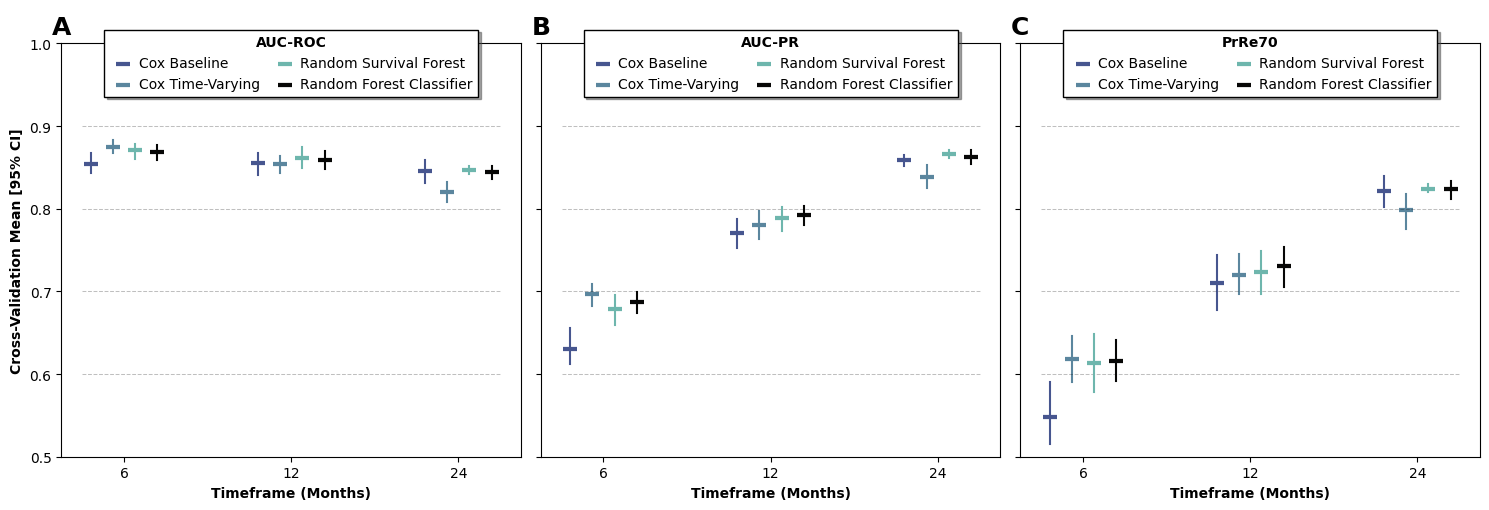

In [ ]:
make_panel(data4, prre)

---
## 8 Variable Set

In [ ]:
data8 = data.loc[(data.v == 1) & (data.Metric.isin(metrics))]
data8

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type,Name
5,bl6,1,6,cox,brier,0.141743,6,Brier,Cox-BL,Cox Baseline
6,bl6,1,6,cox,brier,0.135272,6,Brier,Cox-BL,Cox Baseline
7,bl6,1,6,cox,brier,0.130020,6,Brier,Cox-BL,Cox Baseline
8,bl6,1,6,cox,brier,0.138815,6,Brier,Cox-BL,Cox Baseline
9,bl6,1,6,cox,brier,0.137909,6,Brier,Cox-BL,Cox Baseline
...,...,...,...,...,...,...,...,...,...,...
1665,rsf24,1,24,rsf,prre70,0.838455,24,PrRe70,RSF,Random Survival Forest
1666,rsf24,1,24,rsf,prre70,0.840989,24,PrRe70,RSF,Random Survival Forest
1667,rsf24,1,24,rsf,prre70,0.816467,24,PrRe70,RSF,Random Survival Forest
1668,rsf24,1,24,rsf,prre70,0.831588,24,PrRe70,RSF,Random Survival Forest


### Manual Bootstrap

In [ ]:
pd.concat([
    pd.DataFrame(data8.loc[data8.Metric == "AUC-ROC"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data8.loc[data8.Metric == "AUC-PR"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data8.loc[data8.Metric == "Brier"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data8.loc[data8.Metric == prre].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order])
], axis=1)

,0,0,0,0
model,,,,
bl6,"0.85 [0.84, 0.86]","0.62 [0.61, 0.64]","0.14 [0.13, 0.14]","0.53 [0.5, 0.57]"
rsf6,"0.87 [0.87, 0.88]","0.68 [0.67, 0.69]","0.12 [0.12, 0.12]","0.61 [0.59, 0.65]"
tv6,"0.88 [0.87, 0.89]","0.7 [0.67, 0.71]","0.11 [0.11, 0.12]","0.62 [0.59, 0.66]"
ml6,"0.88 [0.87, 0.89]","0.7 [0.69, 0.71]","0.12 [0.12, 0.13]","0.62 [0.6, 0.66]"
bl12,"0.85 [0.83, 0.86]","0.76 [0.74, 0.77]","0.16 [0.16, 0.17]","0.69 [0.65, 0.72]"
rsf12,"0.86 [0.85, 0.88]","0.79 [0.77, 0.8]","0.15 [0.14, 0.15]","0.73 [0.7, 0.76]"
tv12,"0.86 [0.84, 0.87]","0.78 [0.76, 0.8]","0.16 [0.15, 0.16]","0.73 [0.7, 0.75]"
ml12,"0.87 [0.85, 0.88]","0.8 [0.78, 0.81]","0.14 [0.14, 0.15]","0.74 [0.71, 0.77]"
bl24,"0.84 [0.83, 0.85]","0.85 [0.84, 0.86]","0.17 [0.16, 0.17]","0.81 [0.8, 0.83]"


### 8V Figure

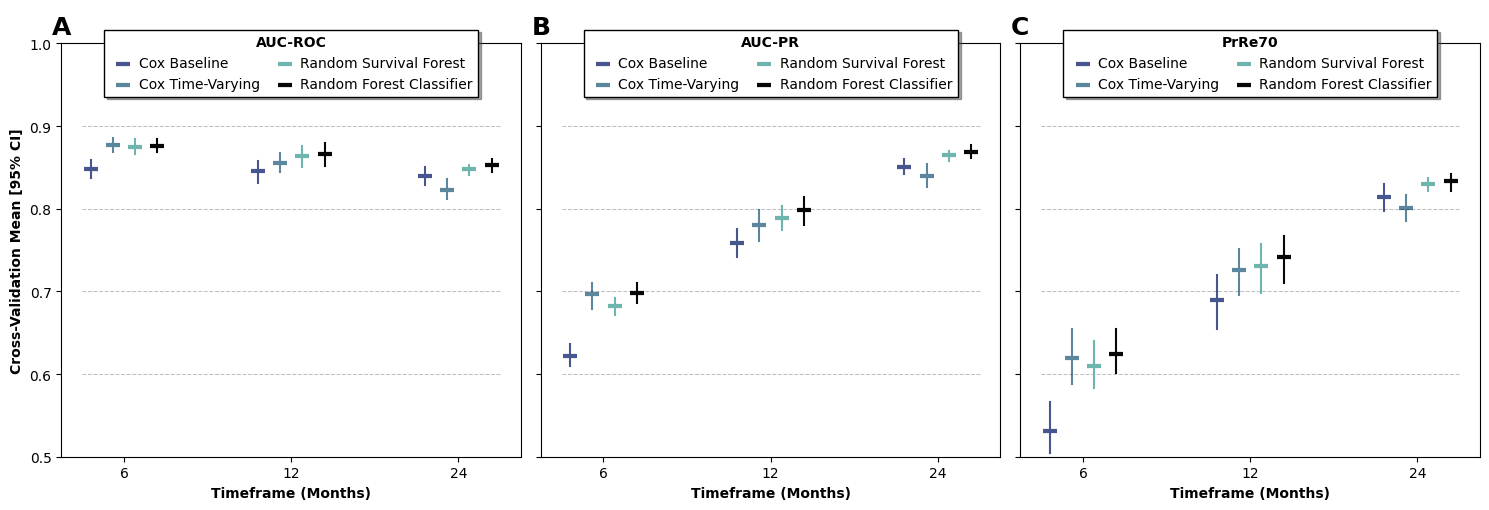

In [ ]:
make_panel(data8, prre)

## 10 Variable Set

In [ ]:
data10 = data.loc[(data.v == 2) & (data.Metric.isin(metrics))]
data10

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type,Name
10,bl6,2,6,cox,brier,0.141642,6,Brier,Cox-BL,Cox Baseline
11,bl6,2,6,cox,brier,0.135008,6,Brier,Cox-BL,Cox Baseline
12,bl6,2,6,cox,brier,0.130171,6,Brier,Cox-BL,Cox Baseline
13,bl6,2,6,cox,brier,0.138931,6,Brier,Cox-BL,Cox Baseline
14,bl6,2,6,cox,brier,0.138129,6,Brier,Cox-BL,Cox Baseline
...,...,...,...,...,...,...,...,...,...,...
1670,rsf24,2,24,rsf,prre70,0.838455,24,PrRe70,RSF,Random Survival Forest
1671,rsf24,2,24,rsf,prre70,0.838767,24,PrRe70,RSF,Random Survival Forest
1672,rsf24,2,24,rsf,prre70,0.820690,24,PrRe70,RSF,Random Survival Forest
1673,rsf24,2,24,rsf,prre70,0.827407,24,PrRe70,RSF,Random Survival Forest


### Manual Bootstrap

In [ ]:
pd.concat([
    pd.DataFrame(data10.loc[data10.Metric == "AUC-ROC"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data10.loc[data10.Metric == "AUC-PR"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data10.loc[data10.Metric == "Brier"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data10.loc[data10.Metric == prre].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order])
], axis=1)

,0,0,0,0
model,,,,
bl6,"0.85 [0.84, 0.86]","0.62 [0.61, 0.64]","0.14 [0.13, 0.14]","0.53 [0.51, 0.56]"
rsf6,"0.87 [0.87, 0.88]","0.68 [0.67, 0.69]","0.12 [0.11, 0.12]","0.61 [0.59, 0.65]"
tv6,"0.88 [0.87, 0.89]","0.7 [0.67, 0.71]","0.11 [0.11, 0.12]","0.62 [0.59, 0.66]"
ml6,"0.88 [0.87, 0.89]","0.7 [0.69, 0.71]","0.12 [0.12, 0.13]","0.62 [0.61, 0.65]"
bl12,"0.85 [0.83, 0.86]","0.76 [0.74, 0.78]","0.16 [0.16, 0.17]","0.7 [0.65, 0.72]"
rsf12,"0.86 [0.85, 0.88]","0.79 [0.77, 0.8]","0.14 [0.14, 0.15]","0.73 [0.69, 0.76]"
tv12,"0.86 [0.84, 0.87]","0.78 [0.76, 0.8]","0.16 [0.15, 0.16]","0.72 [0.68, 0.75]"
ml12,"0.87 [0.85, 0.88]","0.8 [0.78, 0.82]","0.14 [0.14, 0.15]","0.74 [0.71, 0.77]"
bl24,"0.84 [0.83, 0.85]","0.85 [0.85, 0.86]","0.17 [0.16, 0.17]","0.82 [0.8, 0.83]"


### 10V Figure

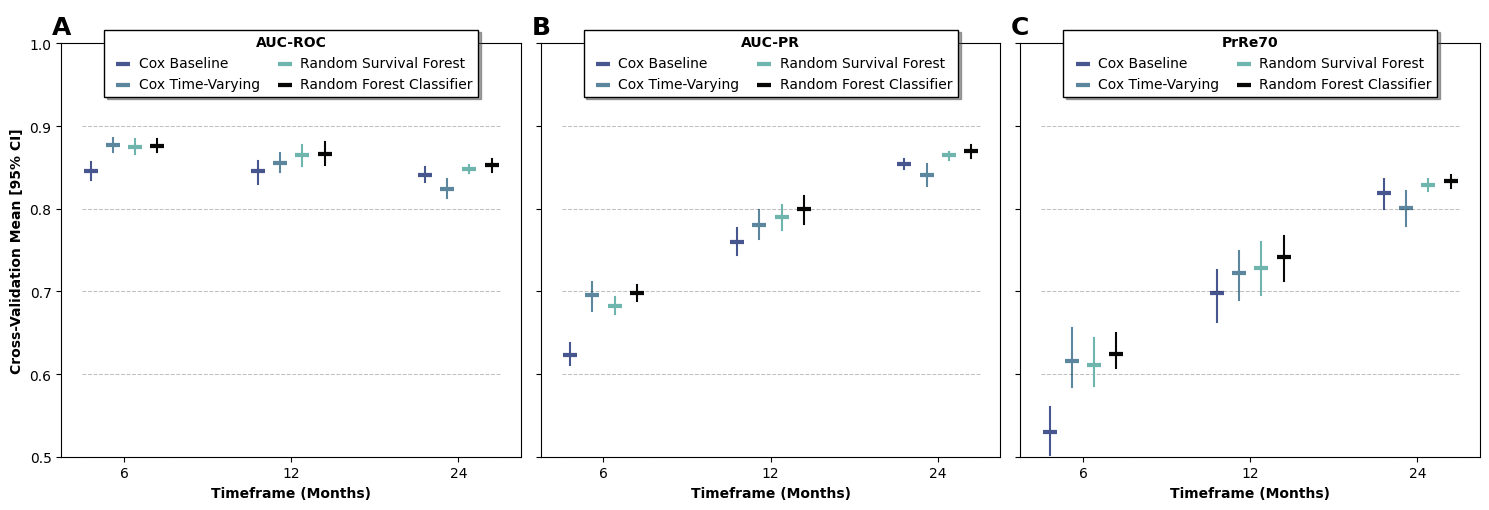

In [ ]:
make_panel(data10, prre)

---
## 13 Variable Set

In [ ]:
data13 = data.loc[(data.v == 3) & (data.Metric.isin(metrics))]
data13

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type,Name
15,bl6,3,6,cox,brier,0.140318,6,Brier,Cox-BL,Cox Baseline
16,bl6,3,6,cox,brier,0.133855,6,Brier,Cox-BL,Cox Baseline
17,bl6,3,6,cox,brier,0.129189,6,Brier,Cox-BL,Cox Baseline
18,bl6,3,6,cox,brier,0.138287,6,Brier,Cox-BL,Cox Baseline
19,bl6,3,6,cox,brier,0.136179,6,Brier,Cox-BL,Cox Baseline
...,...,...,...,...,...,...,...,...,...,...
1675,rsf24,3,24,rsf,prre70,0.833479,24,PrRe70,RSF,Random Survival Forest
1676,rsf24,3,24,rsf,prre70,0.841130,24,PrRe70,RSF,Random Survival Forest
1677,rsf24,3,24,rsf,prre70,0.813816,24,PrRe70,RSF,Random Survival Forest
1678,rsf24,3,24,rsf,prre70,0.830435,24,PrRe70,RSF,Random Survival Forest


### Manual Bootstrap

In [ ]:
pd.concat([
    pd.DataFrame(data13.loc[data13.Metric == "AUC-ROC"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data13.loc[data13.Metric == "AUC-PR"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data13.loc[data13.Metric == "Brier"].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order]),
    pd.DataFrame(data13.loc[data13.Metric == prre].groupby(by="model").apply(
        bootstrappah, "Metric Value"
    )[order])
], axis=1)

,0,0,0,0
model,,,,
bl6,"0.84 [0.84, 0.86]","0.63 [0.62, 0.64]","0.14 [0.13, 0.14]","0.53 [0.5, 0.57]"
rsf6,"0.88 [0.87, 0.89]","0.69 [0.68, 0.7]","0.12 [0.12, 0.12]","0.61 [0.58, 0.66]"
tv6,"0.88 [0.87, 0.89]","0.7 [0.68, 0.71]","0.11 [0.11, 0.12]","0.61 [0.59, 0.65]"
ml6,"0.88 [0.87, 0.89]","0.7 [0.69, 0.71]","0.12 [0.12, 0.13]","0.62 [0.6, 0.65]"
bl12,"0.85 [0.83, 0.85]","0.76 [0.75, 0.78]","0.16 [0.16, 0.17]","0.69 [0.65, 0.71]"
rsf12,"0.86 [0.85, 0.88]","0.79 [0.77, 0.8]","0.15 [0.14, 0.15]","0.73 [0.69, 0.76]"
tv12,"0.86 [0.85, 0.87]","0.78 [0.76, 0.8]","0.16 [0.15, 0.16]","0.72 [0.69, 0.74]"
ml12,"0.87 [0.85, 0.88]","0.8 [0.78, 0.81]","0.14 [0.14, 0.15]","0.74 [0.7, 0.77]"
bl24,"0.84 [0.83, 0.85]","0.85 [0.85, 0.86]","0.16 [0.16, 0.17]","0.82 [0.8, 0.83]"


### 13V Figure

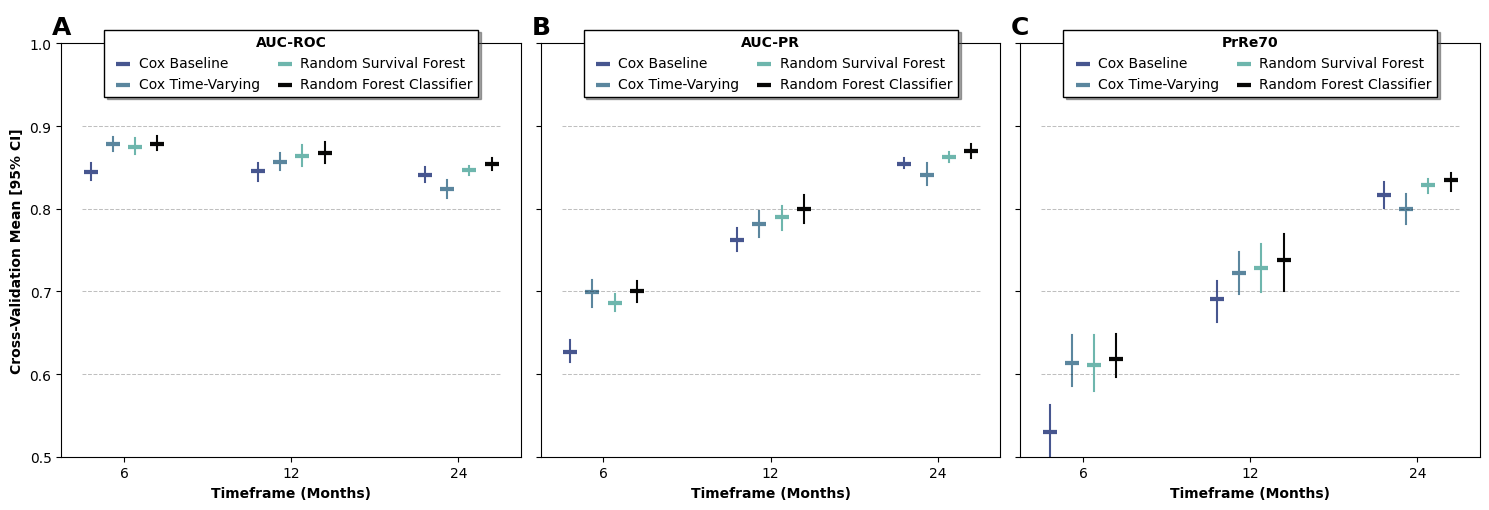

In [ ]:
make_panel(data13, prre)

## Each Model At Its Best PrRe70 (Per Timeframe)

In [9]:
tdata = data.loc[
    (((data.v == 2) & (data.Type == "RSF") & (data.t == 6)) # 10V RSF (6-month)
    | ((data.v == 1) & (data.Type == "RSF") & (data.t == 12)) # 8V RSF (12-month)
    | ((data.v == 1) & (data.Type == "RSF") & (data.t == 24)) # 8V RSF (24-month)
    | ((data.v == 0) & (data.Type == "Cox-BL") & (data.t == 6)) # 4V Cox-BL (6-month)
    | ((data.v == 0) & (data.Type == "Cox-BL") & (data.t == 12)) # 4V Cox-BL (12-month)
    | ((data.v == 0) & (data.Type == "Cox-BL") & (data.t == 24)) # 4V Cox-BL (24-month)
    | ((data.v == 1) & (data.Type == "Cox-TVC") & (data.t == 6)) # 8V Cox-TVC (6-month)
    | ((data.v == 1) & (data.Type == "Cox-TVC") & (data.t == 12)) # 8V Cox-TVC (12-month)
    | ((data.v == 2) & (data.Type == "Cox-TVC") & (data.t == 24)) # 10V Cox-TVC (24-month)
    | ((data.v == 2) & (data.Type == "RFC") & (data.t == 6)) # 10V RFC (6-month)
    | ((data.v == 2) & (data.Type == "RFC") & (data.t == 12)) # 10V RFC (12-month)
    | ((data.v == 2) & (data.Type == "RFC") & (data.t == 24))) # 10V RFC (24-month)
    & (data.Metric.isin(metrics))
]
tdata

,model,v,t,group,variable,Metric Value,Timeframe (Months),Metric,Type,Name
0,bl6,0,6,cox,brier,0.140384,6,Brier,Cox-BL,Cox Baseline
1,bl6,0,6,cox,brier,0.135866,6,Brier,Cox-BL,Cox Baseline
2,bl6,0,6,cox,brier,0.129702,6,Brier,Cox-BL,Cox Baseline
3,bl6,0,6,cox,brier,0.140744,6,Brier,Cox-BL,Cox Baseline
4,bl6,0,6,cox,brier,0.137052,6,Brier,Cox-BL,Cox Baseline
...,...,...,...,...,...,...,...,...,...,...
1665,rsf24,1,24,rsf,prre70,0.838455,24,PrRe70,RSF,Random Survival Forest
1666,rsf24,1,24,rsf,prre70,0.840989,24,PrRe70,RSF,Random Survival Forest
1667,rsf24,1,24,rsf,prre70,0.816467,24,PrRe70,RSF,Random Survival Forest
1668,rsf24,1,24,rsf,prre70,0.831588,24,PrRe70,RSF,Random Survival Forest


### Figure 2

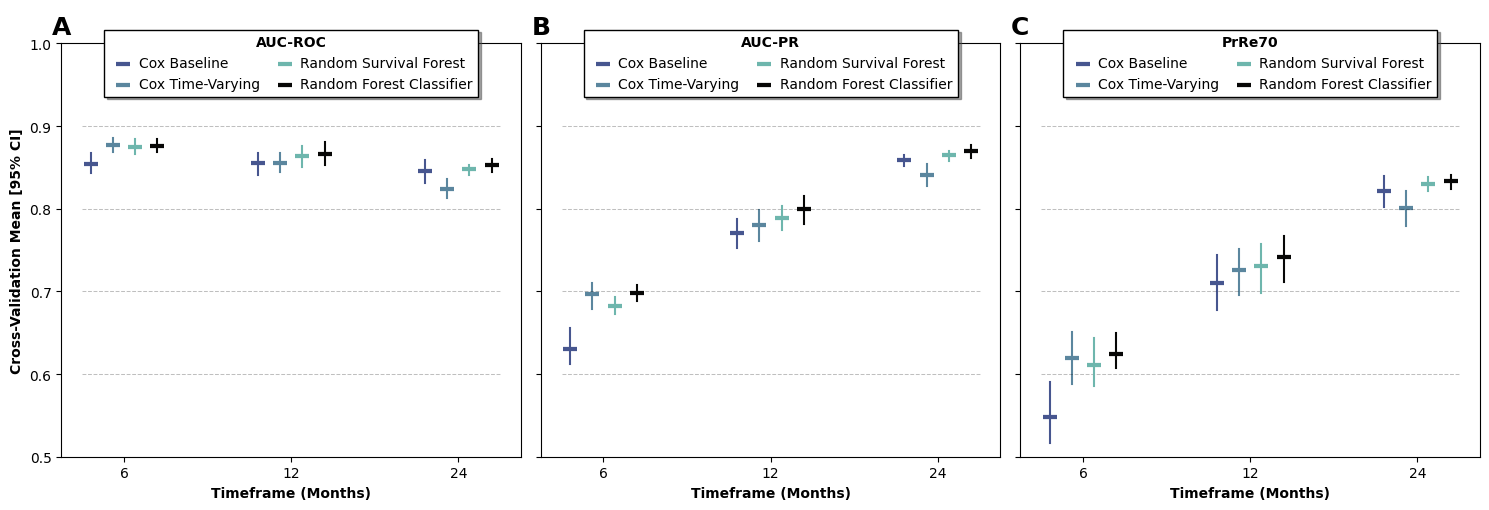

In [11]:
make_panel(tdata, prre)

# ML Examination 1 (Permutation Importances)

In [ ]:
var_id_order = [
    "age", "gender", "egfr_epi_nr", "acr", "calc", "phos", "total_co2", "alb", 
    "diabetes", "pmh_hyper", "pmh_chf", "potassium", "measd_sbp"
]

var_order = [
    "Age", "Female Sex", "eGFR", "ACR", "Calcium", "Phosphate", "Total CO2", "Albumin", 
    "Diabetes", "Hypertension", "Cardiovascular Disease", "Potassium", "Systolic BP"
]

predictor_sets = ["4V", "8V", "10V", "13V"]

rsf_pis, rcf_pis = dict(), dict()

for ri, r in enumerate(results):
    rcf_pis[ri] = r[3][2]
    rsf_pis[ri] = r[3][3]

## Table S4

In [ ]:
rsft = pd.melt(rsf_pis[0][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rsf_pis[0][1:]):
    rsf = rsf * -1

    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

rsfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

rsft = pd.melt(rsf_pis[1][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rsf_pis[1][1:]):

    rsf = rsf * -1
    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

newrsfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

for v in predictor_sets:
    rsfpi[v] = rsfpi[v].str.cat(" " + newrsfpi[v])



rsft = pd.melt(rsf_pis[2][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rsf_pis[2][1:]):

    rsf = rsf * -1
    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

newrsfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

for v in predictor_sets:
    rsfpi[v] = rsfpi[v].str.cat(" " + newrsfpi[v])

rsfpi.to_csv("../out/rsf_perm_imps_{}.csv".format(ulib.get_time_now_str("dmy")))

rsfpi

,4V,8V,10V,13V
Age,"0.0 [0.0, 0.0] 0.01 [0.01, 0.01] 0.02 [0.01, 0...","0.0 [0.0, 0.0] 0.01 [0.01, 0.01] 0.01 [0.01, 0...","0.0 [0.0, 0.0] 0.01 [0.0, 0.01] 0.01 [0.01, 0.01]","0.0 [0.0, 0.0] 0.0 [0.0, 0.01] 0.01 [0.01, 0.01]"
Female Sex,"0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
eGFR,"0.08 [0.08, 0.08] 0.12 [0.12, 0.12] 0.11 [0.1,...","0.05 [0.05, 0.05] 0.08 [0.08, 0.08] 0.07 [0.07...","0.06 [0.06, 0.06] 0.09 [0.08, 0.09] 0.08 [0.08...","0.05 [0.05, 0.05] 0.08 [0.07, 0.08] 0.07 [0.07..."
ACR,"0.02 [0.01, 0.02] 0.03 [0.02, 0.03] 0.04 [0.03...","0.01 [0.01, 0.01] 0.02 [0.01, 0.02] 0.02 [0.02...","0.01 [0.01, 0.01] 0.02 [0.01, 0.02] 0.03 [0.02...","0.01 [0.01, 0.01] 0.01 [0.01, 0.02] 0.02 [0.02..."
Calcium,NaN,"0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
Phosphate,NaN,"0.0 [0.0, 0.0] 0.01 [0.0, 0.01] 0.01 [0.01, 0.01]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.01 [0.01, 0.01]","0.0 [0.0, 0.01] 0.0 [0.0, 0.01] 0.01 [0.01, 0.01]"
Total CO2,NaN,"0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [-0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
Albumin,NaN,"0.0 [0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
Diabetes,NaN,NaN,"-0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]"
Hypertension,NaN,NaN,"0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [-0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]"


## Table S5

In [ ]:
rsft = pd.melt(rcf_pis[0][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rcf_pis[0][1:]):
    rsf = rsf * -1
    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

rcfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

rsft = pd.melt(rcf_pis[1][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rcf_pis[1][1:]):
    rsf = rsf * -1
    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

newrcfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

for v in predictor_sets:
    rcfpi[v] = rcfpi[v].str.cat(" " + newrcfpi[v])

rsft = pd.melt(rcf_pis[2][0] * -1, var_name="Predictor", value_name="HR")
rsft["Predictor Set"] = predictor_sets[0]

for rsfi, rsf in enumerate(rcf_pis[2][1:]):
    rsf = rsf * -1
    newrsf = pd.melt(rsf, var_name="Predictor", value_name="HR")
    newrsf["Predictor Set"] = predictor_sets[rsfi + 1]
    
    rsft = pd.concat([rsft, newrsf], axis=0)

t = pd.DataFrame(rsft.groupby(by=["Predictor", "Predictor Set"]).apply(bootstrappah, "HR")).reset_index()

tcols = t["Predictor Set"].drop_duplicates().ravel()
t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]

newrcfpi = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols
)[predictor_sets]

for v in predictor_sets:
    rcfpi[v] = rcfpi[v].str.cat(" " + newrcfpi[v])

rcfpi.to_csv("../out/rfc_perm_imps_{}.csv".format(ulib.get_time_now_str("dmy")))

rcfpi

,4V,8V,10V,13V
Age,"0.01 [0.01, 0.01] 0.01 [0.01, 0.02] 0.03 [0.02...","0.0 [0.0, 0.0] 0.01 [0.01, 0.01] 0.02 [0.02, 0...","0.0 [0.0, 0.0] 0.01 [0.01, 0.01] 0.02 [0.02, 0...","0.0 [0.0, 0.0] 0.01 [0.01, 0.01] 0.02 [0.01, 0..."
Female Sex,"0.0 [0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [-0.0, 0.0]"
eGFR,"0.12 [0.12, 0.13] 0.14 [0.14, 0.14] 0.12 [0.11...","0.09 [0.09, 0.1] 0.11 [0.1, 0.11] 0.09 [0.08, ...","0.09 [0.09, 0.1] 0.11 [0.11, 0.11] 0.09 [0.09,...","0.09 [0.08, 0.09] 0.1 [0.1, 0.11] 0.08 [0.08, ..."
ACR,"0.01 [0.01, 0.02] 0.03 [0.03, 0.03] 0.04 [0.03...","0.01 [0.0, 0.01] 0.02 [0.02, 0.02] 0.03 [0.02,...","0.01 [0.0, 0.01] 0.02 [0.02, 0.02] 0.03 [0.02,...","0.01 [0.01, 0.01] 0.02 [0.02, 0.02] 0.03 [0.02..."
Calcium,NaN,"0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]"
Phosphate,NaN,"0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [0.0, 0.0] 0.0 [0.0, 0.01] 0.0 [0.0, 0.01]"
Total CO2,NaN,"-0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0]","0.0 [-0.0, 0.0] -0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0]","-0.0 [-0.0, 0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]"
Albumin,NaN,"-0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","-0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
Diabetes,NaN,NaN,"-0.0 [-0.0, -0.0] 0.0 [-0.0, 0.0] 0.0 [0.0, 0.0]","-0.0 [-0.0, -0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
Hypertension,NaN,NaN,"0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [-0.0, 0.0]","0.0 [-0.0, 0.0] 0.0 [0.0, 0.0] 0.0 [0.0, 0.0]"
